# 敵対的生成ネットワーク

```{attention}
作成途中！！！！！！！
```

## 原理とできること

Epoch         10 D-cost 1.2726 D-acc 0.5844 G-cost 0.9265 G-acc 0.5844 


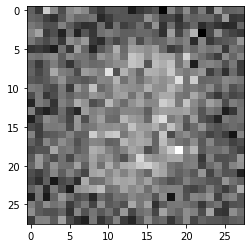

Epoch         20 D-cost 1.3890 D-acc 0.5565 G-cost 0.7543 G-acc 0.5565 


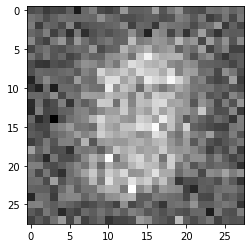

Epoch         30 D-cost 1.2272 D-acc 0.5446 G-cost 0.7550 G-acc 0.5446 


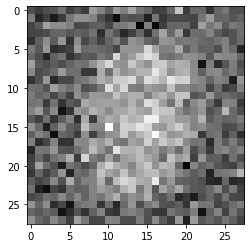

Epoch         40 D-cost 1.2776 D-acc 0.5394 G-cost 0.9228 G-acc 0.5394 


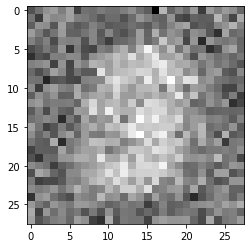

Epoch         50 D-cost 1.4153 D-acc 0.5346 G-cost 0.6583 G-acc 0.5346 


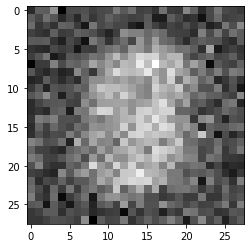

Epoch         60 D-cost 1.5300 D-acc 0.5321 G-cost 0.5926 G-acc 0.5321 


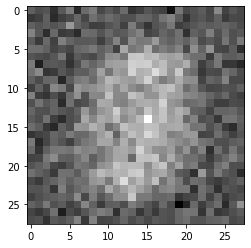

Epoch         70 D-cost 1.4459 D-acc 0.5311 G-cost 0.6737 G-acc 0.5311 


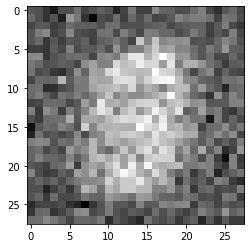

Epoch         80 D-cost 1.3899 D-acc 0.5287 G-cost 0.7185 G-acc 0.5287 


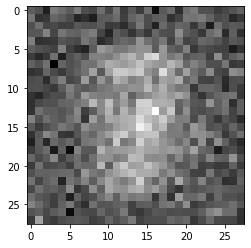

Epoch         90 D-cost 1.5133 D-acc 0.5277 G-cost 0.7649 G-acc 0.5277 


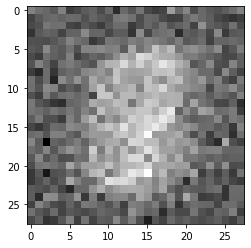

Epoch        100 D-cost 1.3504 D-acc 0.5256 G-cost 0.7021 G-acc 0.5256 


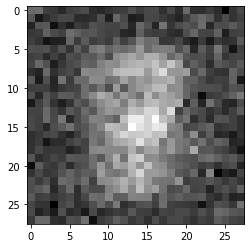

Epoch        110 D-cost 1.2578 D-acc 0.5244 G-cost 0.7651 G-acc 0.5244 


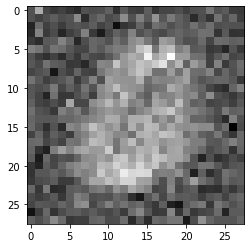

Epoch        120 D-cost 1.4185 D-acc 0.5233 G-cost 0.7428 G-acc 0.5233 


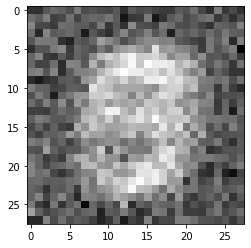

Epoch        130 D-cost 1.4180 D-acc 0.5220 G-cost 0.7132 G-acc 0.5220 


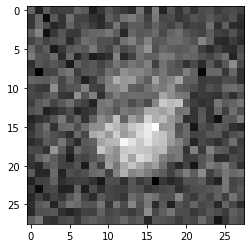

Epoch        140 D-cost 1.4666 D-acc 0.5214 G-cost 0.6562 G-acc 0.5214 


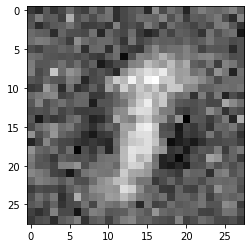

Epoch        150 D-cost 1.4338 D-acc 0.5199 G-cost 0.7531 G-acc 0.5199 


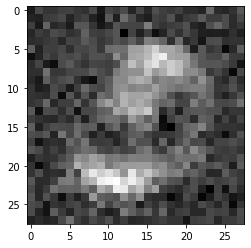

Epoch        160 D-cost 1.3396 D-acc 0.5194 G-cost 0.7431 G-acc 0.5194 


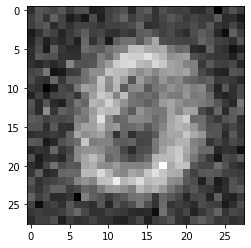

Epoch        170 D-cost 1.3535 D-acc 0.5186 G-cost 0.7257 G-acc 0.5186 


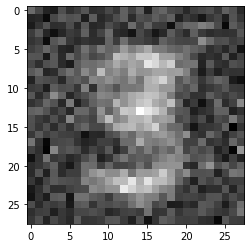

Epoch        180 D-cost 1.3984 D-acc 0.5177 G-cost 0.7120 G-acc 0.5177 


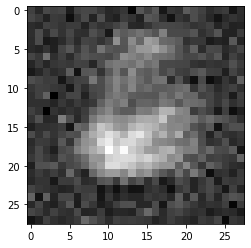

Epoch        190 D-cost 1.4021 D-acc 0.5173 G-cost 0.7093 G-acc 0.5173 


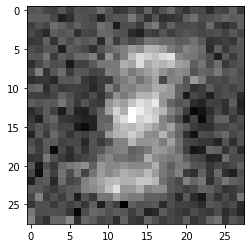

Epoch        200 D-cost 1.3497 D-acc 0.5166 G-cost 0.7177 G-acc 0.5166 


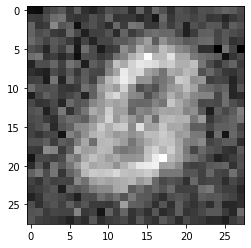

Epoch        210 D-cost 1.3508 D-acc 0.5161 G-cost 0.7430 G-acc 0.5161 


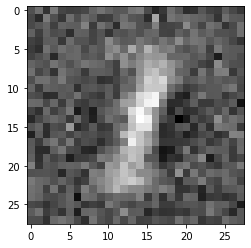

Epoch        220 D-cost 1.3228 D-acc 0.5163 G-cost 0.7699 G-acc 0.5163 


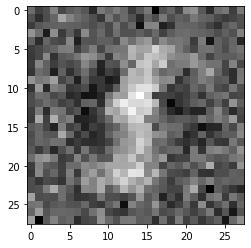

Epoch        230 D-cost 1.3574 D-acc 0.5162 G-cost 0.7607 G-acc 0.5162 


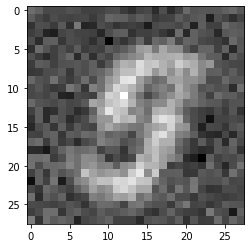

Epoch        240 D-cost 1.3330 D-acc 0.5160 G-cost 0.7533 G-acc 0.5160 


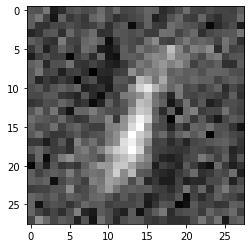

Epoch        250 D-cost 1.3433 D-acc 0.5161 G-cost 0.7611 G-acc 0.5161 


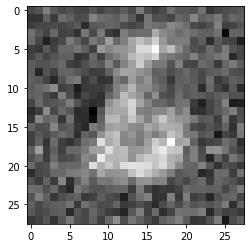

Epoch        260 D-cost 1.3479 D-acc 0.5160 G-cost 0.7489 G-acc 0.5160 


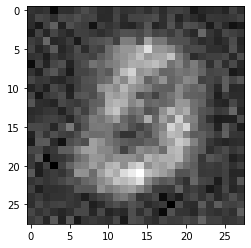

Epoch        270 D-cost 1.3192 D-acc 0.5160 G-cost 0.7769 G-acc 0.5160 


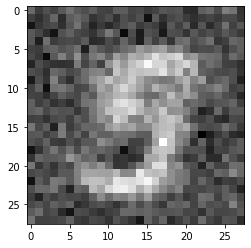

Epoch        280 D-cost 1.3327 D-acc 0.5162 G-cost 0.7632 G-acc 0.5162 


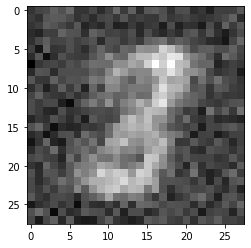

Epoch        290 D-cost 1.3537 D-acc 0.5163 G-cost 0.7726 G-acc 0.5163 


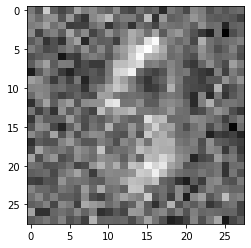

Epoch        300 D-cost 1.3020 D-acc 0.5164 G-cost 0.7927 G-acc 0.5164 


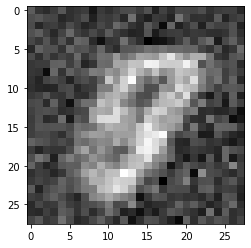

Epoch        310 D-cost 1.3024 D-acc 0.5166 G-cost 0.7921 G-acc 0.5166 


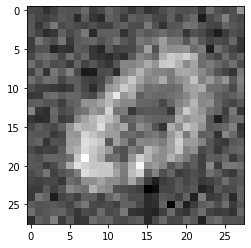

Epoch        320 D-cost 1.2806 D-acc 0.5168 G-cost 0.8187 G-acc 0.5168 


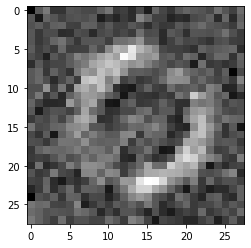

Epoch        330 D-cost 1.3252 D-acc 0.5171 G-cost 0.7933 G-acc 0.5171 


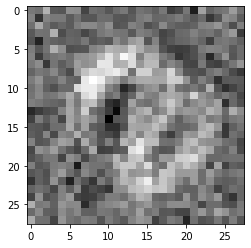

Epoch        340 D-cost 1.3035 D-acc 0.5173 G-cost 0.8106 G-acc 0.5173 


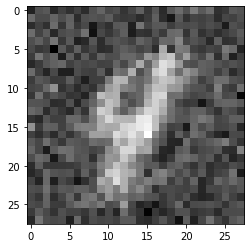

Epoch        350 D-cost 1.3142 D-acc 0.5175 G-cost 0.8018 G-acc 0.5175 


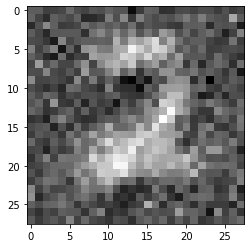

Epoch        360 D-cost 1.3156 D-acc 0.5177 G-cost 0.7870 G-acc 0.5177 


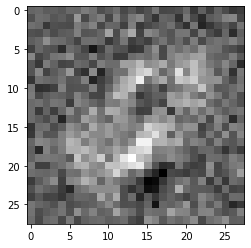

Epoch        370 D-cost 1.3109 D-acc 0.5179 G-cost 0.8035 G-acc 0.5179 


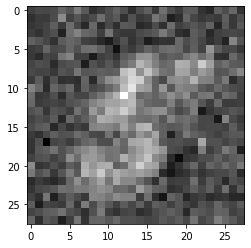

Epoch        380 D-cost 1.3189 D-acc 0.5178 G-cost 0.7935 G-acc 0.5178 


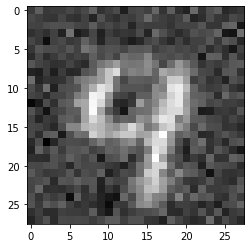

Epoch        390 D-cost 1.3114 D-acc 0.5178 G-cost 0.7784 G-acc 0.5178 


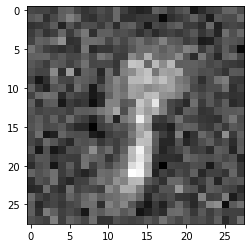

Epoch        400 D-cost 1.3123 D-acc 0.5178 G-cost 0.7757 G-acc 0.5178 


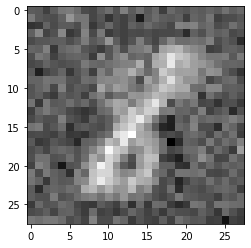

Epoch        410 D-cost 1.3141 D-acc 0.5178 G-cost 0.7889 G-acc 0.5178 


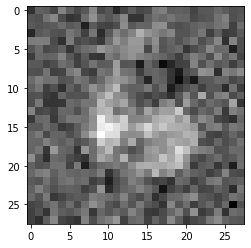

Epoch        420 D-cost 1.3177 D-acc 0.5178 G-cost 0.7974 G-acc 0.5178 


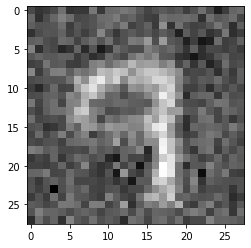

Epoch        430 D-cost 1.3100 D-acc 0.5178 G-cost 0.7909 G-acc 0.5178 


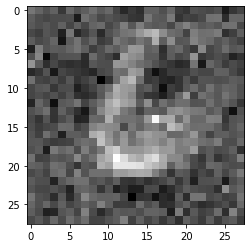

Epoch        440 D-cost 1.3100 D-acc 0.5178 G-cost 0.8032 G-acc 0.5178 


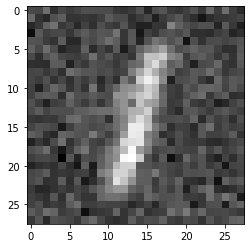

Epoch        450 D-cost 1.3068 D-acc 0.5178 G-cost 0.7801 G-acc 0.5178 


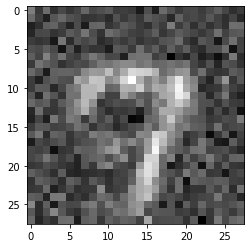

Epoch        460 D-cost 1.3066 D-acc 0.5178 G-cost 0.7973 G-acc 0.5178 


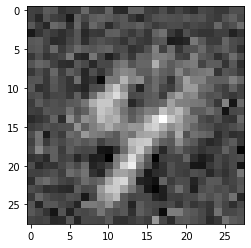

Epoch        470 D-cost 1.3214 D-acc 0.5178 G-cost 0.7996 G-acc 0.5178 


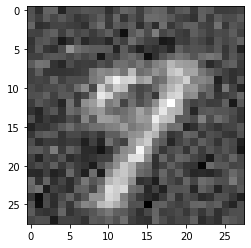

Epoch        480 D-cost 1.3083 D-acc 0.5178 G-cost 0.7978 G-acc 0.5178 


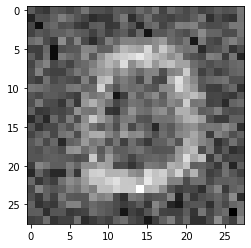

Epoch        490 D-cost 1.2989 D-acc 0.5179 G-cost 0.7989 G-acc 0.5179 


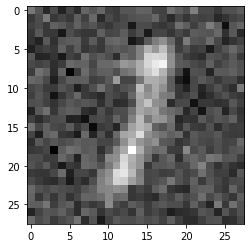

Epoch        500 D-cost 1.3062 D-acc 0.5179 G-cost 0.8041 G-acc 0.5179 


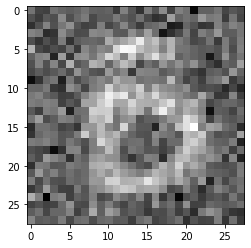

In [14]:
#!/usr/bin/env python3
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
tf.random.set_seed(0)
np.random.seed(0)
#np.set_printoptions(threshold=np.inf,linewidth=np.inf,suppress=True,precision=12)

def main():
    MiniBatchSize = 300
    NoiseSize = 100
    MaxEpoch = 500
    
    (learnX, learnT), (_, _) = tf.keras.datasets.mnist.load_data()
    learnX = learnX.reshape([60000, 784])
    learnX = (learnX - 127.5) / 127.5
    
    generator = Generator()
    discriminator = Discriminator()
    
    costComputer = tf.keras.losses.SparseCategoricalCrossentropy()
    accuracyComputer = tf.keras.metrics.SparseCategoricalAccuracy()
    
    optimizerGenerator = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizerDiscriminator = tf.keras.optimizers.Adam(learning_rate=0.00004)
    
    def generatorCostFunction(discriminatorOutputFromGenerated): # 生成器のコストの引数は生成器の出力を識別器に入れた結果．生成器としては全部正解を出しているはずなので教師はすべて1となるはず．そのように学習すべき．
        cost = costComputer(tf.ones(discriminatorOutputFromGenerated.shape[0]), discriminatorOutputFromGenerated)
        accuracy = accuracyComputer(tf.ones(discriminatorOutputFromGenerated.shape[0]), discriminatorOutputFromGenerated)
        return cost, accuracy
    
    def discriminatorCostFunction(discriminatorOutputFromReal,discriminatorOutputFromGenerated): # 識別器のコストの引数は本物の情報を識別器に入れた結果と生成器の出力を識別器に入れた結果．
        realCost = costComputer(tf.ones(discriminatorOutputFromReal.shape[0]), discriminatorOutputFromReal) # 本物の情報の場合はすべて正例（1）と判断すべき．これが例のコスト関数の左の項に相当．
        fakeCost = costComputer(tf.zeros(discriminatorOutputFromGenerated.shape[0]), discriminatorOutputFromGenerated) # 偽物の情報の場合はすべて負例（0）と判断すべき．これが例のコスト関数の右の項に相当．
        cost = realCost + fakeCost
        realAccuracy = accuracyComputer(tf.ones(discriminatorOutputFromReal.shape[0]), discriminatorOutputFromReal)
        fakeAccuracy = accuracyComputer(tf.zeros(discriminatorOutputFromGenerated.shape[0]), discriminatorOutputFromGenerated)
        accuracy=(realAccuracy + fakeAccuracy) / 2
        return cost, accuracy
    
    @tf.function()
    def run(generator, discriminator, noiseVector, realVector):
        with tf.GradientTape() as generatorTape, tf.GradientTape() as discriminatorTape:
            generatedVector = generator(noiseVector) # 生成器によるデータの生成．
            discriminatorOutputFromGenerated = discriminator(generatedVector) # その生成データを識別器に入れる．
            discriminatorOutputFromReal = discriminator(realVector) # 本物データを識別器に入れる．
            
            discriminatorCost, discriminatorAccuracy = discriminatorCostFunction(discriminatorOutputFromReal, discriminatorOutputFromGenerated)
            gradientDiscriminator = discriminatorTape.gradient(discriminatorCost, discriminator.trainable_variables)
            optimizerDiscriminator.apply_gradients(zip(gradientDiscriminator, discriminator.trainable_variables))
            
            generatorCost, generatorAccuracy = generatorCostFunction(discriminatorOutputFromGenerated)
            gradientGenerator = generatorTape.gradient(generatorCost,generator.trainable_variables)
            optimizerGenerator.apply_gradients(zip(gradientGenerator,generator.trainable_variables))
            
            return discriminatorCost, discriminatorAccuracy, generatorCost, generatorAccuracy
    
    # ミニバッチセットの生成
    learnX = tf.data.Dataset.from_tensor_slices(learnX)
    learnT = tf.data.Dataset.from_tensor_slices(learnT)
    learnA = tf.data.Dataset.zip((learnX, learnT)).shuffle(60000).batch(MiniBatchSize) # 今回はインプットデータしか使わないけど後にターゲットデータを使う場合があるため．
    miniBatchNumber = len(list(learnA.as_numpy_iterator()))
    for epoch in range(1,MaxEpoch+1):
        discriminatorCost, discriminatorAccuracy, generatorCost, generatorAccuracy = 0, 0, 0, 0
        for learnx, _ in learnA:
            noiseVector = generateNoise(MiniBatchSize, NoiseSize) # ミニバッチサイズで100個の要素からなるノイズベクトルを生成．
            discriminatorCostTmp, discriminatorAccuracyTmp, generatorCostTmp, generatorAccuracyTmp = run(generator, discriminator, noiseVector, learnx)
            discriminatorCost += discriminatorCostTmp / miniBatchNumber
            discriminatorAccuracy += discriminatorAccuracyTmp / miniBatchNumber
            generatorCost += generatorCostTmp / miniBatchNumber
            generatorAccuracy += generatorAccuracyTmp / miniBatchNumber
        if epoch%10 == 0:
            print("Epoch {:10d} D-cost {:6.4f} D-acc {:6.4f} G-cost {:6.4f} G-acc {:6.4f} ".format(epoch,float(discriminatorCost),float(discriminatorAccuracy),float(generatorCost),float(generatorAccuracy)))
            validationNoiseVector = generateNoise(1, NoiseSize)
            validationOutput = generator(validationNoiseVector)
            validationOutput = np.asarray(validationOutput).reshape([1, 28, 28])
            plt.imshow(validationOutput[0], cmap = "gray")
            plt.pause(1)
            #print(validationOutput)

class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.d1 = tf.keras.layers.Dense(units=128)
        self.d2 = tf.keras.layers.Dense(units=128)
        self.d3 = tf.keras.layers.Dense(units=128)
        self.d4 = tf.keras.layers.Dense(units=2,activation="softmax")
        self.a = tf.keras.layers.LeakyReLU()
        self.d = tf.keras.layers.Dropout(0.5)
    def call(self,x):
        y = self.d1(x)
        y = self.a(y)
        y = self.d(y)
        y = self.d2(y)
        y = self.a(y)
        y = self.d(y)
        y = self.d3(y)
        y = self.a(y)
        y = self.d(y)
        y = self.d4(y)
        return y

class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator,self).__init__()
        self.d1=tf.keras.layers.Dense(units=256)
        self.d2=tf.keras.layers.Dense(units=256)
        self.d3=tf.keras.layers.Dense(units=784)
        self.a=tf.keras.layers.LeakyReLU()
        self.b1=tf.keras.layers.BatchNormalization()
        self.b2=tf.keras.layers.BatchNormalization()
    def call(self,x):
        y = self.d1(x)
        y = self.a(y)
        y = self.b1(y)
        y = self.d2(y)
        y = self.a(y)
        y = self.b2(y)
        y = self.d3(y)
        return y
    
def generateNoise(miniBatchSize,randomNoiseSize):
    return np.random.uniform(-1,1,size=(miniBatchSize,randomNoiseSize)).astype("float32")

if __name__ == "__main__":
    main()

敵対的生成ネットワークとは

### 原理

生成器，識別器，生成器のコスト関数，識別器のコスト関数

トランスフォーマーとはアテンションとポジショナルエンコードといわれる技術を用いて，再帰型ニューラルネットワークとは異なる方法で文字列を処理することができるニューラルネットワークの構造です．機械翻訳や質問応答に利用することができます．

例えば，機械翻訳の場合，翻訳したい文字列を入力データ，翻訳結果の文字列を教師データとして利用します．構築した人工知能は翻訳したい文字列を入力値として受け取り，配列を出力します．配列の各要素は文字の個数と同じサイズのベクトル（その要素が何の文字なのかを示す確率ベクトル）です．

トランスフォーマーはエンコーダーとデコーダーという構造からなります．エンコーダーは配列（機械翻訳の場合，翻訳したい配列）を入力にして，同じ長さの配列を出力します．デコーダーも配列（機械翻訳の場合，翻訳で得たい配列）とエンコーダーが出力した配列を入力にして同じ長さの配列（各要素は確率ベクトル）を出力します．エンコーダーが出力した配列情報をデコーダーで処理する際にアテンションという技術が利用されます．

<img src="https://github.com/yamada-kd/binds-training/blob/main/image/transformer.svg?raw=1" width="100%" />

エンコーダーとデコーダー間のアテンション以外にも，エンコーダーとデコーダーの内部でもそれぞれアテンション（セルフアテンション）が計算されます．アテンションは文字列内における文字の関連性を計算します．

トランスフォーマーは再帰型ニューラルネットワークで行うような文字の逐次的な処理が不要です．よって，計算機の並列化性能をより引き出せます．扱える文脈の長さも無限です（再帰型ニューラルネットワークでも理論上無限です．）．

このトランスフォーマーはものすごい性能を発揮しており，これまでに作られてきた様々な構造を過去のものとしました．特に応用の範囲が広いのはトランスフォーマーのエンコーダーの部分です．BERT と呼ばれる方法を筆頭に自然言語からなる配列を入力にして何らかの分散表現を出力する方法として自然言語処理に関わる様々な研究開発に利用されています．

（会話でトランスフォーマーという場合は，トランスフォーマーのエンコーダーまたはデコーダーのことを言っている場合があります．エンコーダー・デコーダー，エンコーダー，デコーダー，この3個でそれぞれできることが異なります．）

```{hint}
実用上，配列を入力にして配列を返す構造とだけ覚えておけば問題はないと思います．
```

### できること

Hugging Face で扱うことができるタスクは以下に示すものがあります．これ以外にもありますが自然言語処理に関する代表的なタスクを抽出しました．括弧内の文字列は実際に Hugging Face を利用する際に指定するオプションです（後で利用します．）．

    

*   感情分析（`sentiment-analysis`）：入力した文章が有する感情を予測
*   特徴抽出（`feature-extraction`）：入力した文章をその特徴を示すベクトルに変換
*   穴埋め（`fill-mask`）：文章中のマスクされた単語を予測
*   固有表現抽出（`ner`）：入力した文章中の固有表現（名前とか場所とか）にラベルをつける
*   質問応答（`question-answering`）：質問文とその答えが含まれる何らかの説明文を入力として解答文を生成
*   要約（`summarization`）：入力した文章を要約
*   文章生成（`text-generation`）：文章を入力にして，その文章に続く文章を生成
*   翻訳（`translation`）：文章を他の言語に翻訳
*   ゼロショット文章分類（`zero-shot-classification`）：文章とそれが属する可能性があるいくつかのカテゴリを入力にしてその文章をひとつのカテゴリに分類
    
    

## 基本的な構造

最も基本的な GAN の構造は以下のプログラムに含まれるものです．

In [ ]:
#!/usr/bin/env python3
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(0)
np.random.seed(0)

def main():
    # ハイパーパラメータの設定
    MiniBatchSize = 300
    NoiseSize = 100 # GANはランダムなノイズベクトルから何かを生成する方法なので，そのノイズベクトルのサイズを設定する．
    MaxEpoch = 500
    
    # データセットの読み込み
    (learnX, learnT), (_, _) = tf.keras.datasets.mnist.load_data()
    learnX = learnX.reshape([60000, 784])
    learnX = (learnX - 127.5) / 127.5
    
    # 生成器と識別器の構築
    generator = Generator() # 下のクラスを参照．
    discriminator = Discriminator() # 下のクラスを参照．
    
    # コスト関数と正確度を計算する関数の生成
    costComputer = tf.keras.losses.SparseCategoricalCrossentropy()
    accuracyComputer = tf.keras.metrics.SparseCategoricalAccuracy()
    
    # オプティマイザは生成器と識別器で別々のものを利用
    optimizerGenerator = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizerDiscriminator = tf.keras.optimizers.Adam(learning_rate=0.00004)
    
    # 生成器を成長させるためのコストを計算する関数
    def generatorCostFunction(discriminatorOutputFromGenerated):
        cost = costComputer(tf.ones(discriminatorOutputFromGenerated.shape[0]), discriminatorOutputFromGenerated) # 生成器のコストの引数は生成器の出力を識別器に入れた結果．生成器としては全部正解を出しているはずなので教師はすべて1となるはず．そのように学習すべき．
        accuracy = accuracyComputer(tf.ones(discriminatorOutputFromGenerated.shape[0]), discriminatorOutputFromGenerated)
        return cost, accuracy
    
    # 識別器を成長させるためのコストを計算する関数
    def discriminatorCostFunction(discriminatorOutputFromReal,discriminatorOutputFromGenerated): # 識別器のコストの引数は本物の情報を識別器に入れた結果と生成器の出力を識別器に入れた結果．
        realCost = costComputer(tf.ones(discriminatorOutputFromReal.shape[0]), discriminatorOutputFromReal) # 本物の情報の場合はすべて正例（1）と判断すべき．これが例のコスト関数の左の項に相当．
        fakeCost = costComputer(tf.zeros(discriminatorOutputFromGenerated.shape[0]), discriminatorOutputFromGenerated) # 偽物の情報の場合はすべて負例（0）と判断すべき．これが例のコスト関数の右の項に相当．
        cost = realCost + fakeCost
        realAccuracy = accuracyComputer(tf.ones(discriminatorOutputFromReal.shape[0]), discriminatorOutputFromReal)
        fakeAccuracy = accuracyComputer(tf.zeros(discriminatorOutputFromGenerated.shape[0]), discriminatorOutputFromGenerated)
        accuracy=(realAccuracy + fakeAccuracy) / 2
        return cost, accuracy
    
    @tf.function()
    def run(generator, discriminator, noiseVector, realVector):
        with tf.GradientTape() as generatorTape, tf.GradientTape() as discriminatorTape:
            generatedVector = generator(noiseVector) # 生成器によるデータの生成．
            discriminatorOutputFromGenerated = discriminator(generatedVector) # その生成データを識別器に入れる．
            discriminatorOutputFromReal = discriminator(realVector) # 本物データを識別器に入れる．
            # 識別器の成長
            discriminatorCost, discriminatorAccuracy = discriminatorCostFunction(discriminatorOutputFromReal, discriminatorOutputFromGenerated)
            gradientDiscriminator = discriminatorTape.gradient(discriminatorCost, discriminator.trainable_variables) # 識別器のパラメータだけで勾配を計算．つまり生成器のパラメータは行わない．
            optimizerDiscriminator.apply_gradients(zip(gradientDiscriminator, discriminator.trainable_variables))
            # 生成器の成長
            generatorCost, generatorAccuracy = generatorCostFunction(discriminatorOutputFromGenerated)
            gradientGenerator = generatorTape.gradient(generatorCost,generator.trainable_variables) # 生成器のパラメータで勾配を計算．
            optimizerGenerator.apply_gradients(zip(gradientGenerator,generator.trainable_variables))
            return discriminatorCost, discriminatorAccuracy, generatorCost, generatorAccuracy
    
    # ミニバッチセットの生成
    learnX = tf.data.Dataset.from_tensor_slices(learnX) # このような方法を使うと簡単にミニバッチを実装することが可能．
    learnT = tf.data.Dataset.from_tensor_slices(learnT)
    learnA = tf.data.Dataset.zip((learnX, learnT)).shuffle(60000).batch(MiniBatchSize) # 今回はインプットデータしか使わないけど後にターゲットデータを使う場合があるため．
    miniBatchNumber = len(list(learnA.as_numpy_iterator()))
    # 学習ループ
    for epoch in range(1,MaxEpoch+1):
        discriminatorCost, discriminatorAccuracy, generatorCost, generatorAccuracy = 0, 0, 0, 0
        for learnx, _ in learnA:
            noiseVector = generateNoise(MiniBatchSize, NoiseSize) # ミニバッチサイズで100個の要素からなるノイズベクトルを生成．
            discriminatorCostTmp, discriminatorAccuracyTmp, generatorCostTmp, generatorAccuracyTmp = run(generator, discriminator, noiseVector, learnx)
            discriminatorCost += discriminatorCostTmp / miniBatchNumber
            discriminatorAccuracy += discriminatorAccuracyTmp / miniBatchNumber
            generatorCost += generatorCostTmp / miniBatchNumber
            generatorAccuracy += generatorAccuracyTmp / miniBatchNumber
        # 疑似的なテスト
        if epoch%10 == 0:
            print("Epoch {:10d} D-cost {:6.4f} D-acc {:6.4f} G-cost {:6.4f} G-acc {:6.4f} ".format(epoch,float(discriminatorCost),float(discriminatorAccuracy),float(generatorCost),float(generatorAccuracy)))
            validationNoiseVector = generateNoise(1, NoiseSize)
            validationOutput = generator(validationNoiseVector)
            validationOutput = np.asarray(validationOutput).reshape([1, 28, 28])
            plt.imshow(validationOutput[0], cmap = "gray")
            plt.pause(1)

# 入力されたデータを0か1に分類するネットワーク
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.d1 = tf.keras.layers.Dense(units=128)
        self.d2 = tf.keras.layers.Dense(units=128)
        self.d3 = tf.keras.layers.Dense(units=128)
        self.d4 = tf.keras.layers.Dense(units=2, activation="softmax")
        self.a = tf.keras.layers.LeakyReLU()
        self.d = tf.keras.layers.Dropout(0.5)
    def call(self,x):
        y = self.d1(x)
        y = self.a(y)
        y = self.d(y)
        y = self.d2(y)
        y = self.a(y)
        y = self.d(y)
        y = self.d3(y)
        y = self.a(y)
        y = self.d(y)
        y = self.d4(y)
        return y

# 入力されたベクトルから別のベクトルを生成するネットワーク
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator,self).__init__()
        self.d1=tf.keras.layers.Dense(units=256)
        self.d2=tf.keras.layers.Dense(units=256)
        self.d3=tf.keras.layers.Dense(units=784)
        self.a=tf.keras.layers.LeakyReLU()
        self.b1=tf.keras.layers.BatchNormalization()
        self.b2=tf.keras.layers.BatchNormalization()
    def call(self,x):
        y = self.d1(x)
        y = self.a(y)
        y = self.b1(y)
        y = self.d2(y)
        y = self.a(y)
        y = self.b2(y)
        y = self.d3(y)
        return y

def generateNoise(miniBatchSize, randomNoiseSize):
    return np.random.uniform(-1,1,size=(miniBatchSize,randomNoiseSize)).astype("float32")

if __name__ == "__main__":
    main()

とても簡単に自然言語処理を実現することができる利用方法を紹介します．世界最高性能を求めたいとかでないなら，ここで紹介する方法を利用して様々なことを達成できると思います．

### 感情分析

最も簡単な `tranformers` の利用方法は以下のようになると思います．`pipeline` を読み込んで，そこに取り組みたいタスク（`sentiment-analysis`）を指定します．初回の起動の際には事前学習済みモデルがダウンロードされるため時間がかかります．

In [ ]:
#!/usr/bin/env python3
from transformers import pipeline
 
def main():
    classifier = pipeline("sentiment-analysis")
    text = "I have a pen."
    result = classifier(text)
    print(result)

if __name__ == "__main__":
    main()

入力した文章がポジティブな文章なのかネガティブな文章なのかを分類できます．ここでは1個の文章を入力しましたが，以下のように2個以上の文章も入力可能です．

In [ ]:
#!/usr/bin/env python3
from transformers import pipeline
 
def main():
    classifier = pipeline("sentiment-analysis")
    litext = ["I've been waiting for a HuggingFace course my whole life.", "I hate this so much!"]
    result = classifier(litext)
    print(result)

if __name__ == "__main__":
    main()

## WGAN-gp

これまでに利用したものとは異なるモデルを利用したいとか，自身が持っているデータセットにより適合させたいとかの応用的な利用方法を紹介します．

### 他のモデルの利用

これまでに，Hugging Face が自動でダウンロードしてくれたデフォルトの事前学習済みモデルを利用した予測を行いましたが，そうでなくて，モデルを指定することもできます．以下のページをご覧ください．Model Hub と言います．

https://huggingface.co/models?pipeline_tag=text-generation&sort=downloads


この Model Hub の Tasks というところでタグを選択できます．例えば，Text Generation の `distilgpt2` を利用するには以下のように書きます．

In [ ]:
#!/usr/bin/env python3
from transformers import pipeline
 
def main():
    generator = pipeline("text-generation", model="distilgpt2")
    text = "In this course, we will teach you how to"
    result = generator(text)
    print(result)

if __name__ == "__main__":
    main()

## Conditional GAN

```{note}
終わりです．
```